In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import torch
import random
import numpy as np

# Set seed
torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.cuda.manual_seed_all(7)
np.random.seed(7)
random.seed(7)

# **Load the dataset: en (English)**

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load train and test datasets
train_df = pd.read_csv("train.tsv",  sep='\t', on_bad_lines='skip')
test_df = pd.read_csv("test.tsv",  sep='\t', on_bad_lines='skip')
print('Train dataset size:', train_df.shape)
print('Test dataset size:', test_df.shape)

Train dataset size: (33845, 6)
Test dataset size: (21832, 6)


In [ ]:
# Since we will only focus on a binary classification, we do not need the id, prompt and model variables
# We will mantain the domain variable to later study how well the model works depending on the domain
train_df = train_df.drop(['id', 'prompt', 'model'], axis=1)
test_df = test_df.drop(['id', 'prompt', 'model'], axis=1)

## Split the data
We will first split the train and test dataset into X_train, y_train, domains_train and X_test, y_test, domains_test, respectivately.

In [ ]:
# Texts
X_train = train_df['text']
X_test = test_df['text']

# Extract labels
y_train = train_df['label']
y_test = test_df['label']

# Extract domain column, we will use it later
domains_train = train_df['domain']
domains_test = test_df['domain']

# Preprocessing
We will create a function that cleans the texts in our dataset.

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stopwords_en = stopwords.words("english")

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re

def clean_text(text):
    # transform to lower case
    text=str(text).lower()
    # tokenize
    tokens=word_tokenize(text)
    # eliminate stopwords
    tokens = [word for word in tokens if word not in stopwords_en]
    # apply stemming
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminate words with length lower than 3
    min_length = 3
    # ignore words that contain a digit or a special symbol
    p = re.compile('^[a-zA-Z]+$')

    # stored clean tokens
    filtered_tokens=[]
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens.append(token)

    return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Label Encoding
Transform the labels to digit format, i.e., 0 : *generated*; 1 : *human*.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = y_train.tolist()
y_test = y_test.tolist()

le = LabelEncoder()

print("Before transforming: ", y_train[:10])
y_train = le.fit_transform(y_train)
labels = le.classes_
print("After transforming:", y_train[:10])

print("Before transforming: ", y_test[:10])
y_test = le.transform(y_test)
print("After transforming:", y_test[:10])

label2idx={}
for index, label in enumerate(labels):
    label2idx.update([(label, index)])
print('Labels:', label2idx)

Before transforming:  ['generated', 'generated', 'generated', 'human', 'human', 'generated', 'generated', 'human', 'generated', 'generated']
After transforming: [0 0 0 1 1 0 0 1 0 0]
Before transforming:  ['human', 'human', 'generated', 'human', 'human', 'generated', 'human', 'generated', 'generated', 'human']
After transforming: [1 1 0 1 1 0 1 0 0 1]
Labels: {'generated': 0, 'human': 1}


# SVM Pipeline
Create a pipeline that executes the following:

1. Use of Bag of Words (BoW) to represent our texts.
2. Apply TF-IDF to transform our texts: reflect the importance of a word in a text relative to a collection of texts (dataset).
3. Implement Classification algorithm.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

pipeline_SVC = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),    # represent texts using Bag of Words
    ('tf', TfidfTransformer()),                       # tranform texts using TF-IDF
    ('svm', SVC()),                                   # implement SVC algorithm
])

## Cross-Validation
Apply RandomizedSearchCV with different combinations of parameters, and evaluate over validation dataset to find the best parameters.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Set different parameters values
param_grid_SVC = {
    'svm__C': np.arange(0, 1, 0.05),
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
}
rand_SVC = RandomizedSearchCV(estimator=pipeline_SVC, param_distributions=param_grid_SVC, n_iter=5, scoring='f1_macro', cv=5, verbose=False)
rand_SVC.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 186, in fit
    raise TypeError("Sparse precomputed kernels are not supported.")
TypeError: Sp

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('bow',
                                              CountVectorizer(analyzer=<function clean_text at 0x7e3acbcaf760>)),
                                             ('tf', TfidfTransformer()),
                                             ('svm', SVC())]),
                   n_iter=5,
                   param_distributions={'svm__C': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'svm__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid',
                                                        'precomputed']},
                   scoring='f1_macro', verbose=False)

In [ ]:
rand_SVC.best_score_

0.7355731769379237

In [ ]:
rand_SVC.best_params_

{'svm__kernel': 'rbf', 'svm__C': 0.35000000000000003}

In [ ]:
rand_SVC.cv_results_

{'mean_fit_time': array([273.36085935, 445.35235381, 264.62250414, 632.21670389,
         46.61586595]),
 'std_fit_time': array([6.84672048, 0.74725012, 9.00358394, 7.41177936, 2.09374078]),
 'mean_score_time': array([53.68054061, 54.0826138 , 40.16931329, 52.4082531 ,  0.        ]),
 'std_score_time': array([0.66976953, 0.66027787, 0.15971201, 0.40254602, 0.        ]),
 'param_svm__kernel': masked_array(data=['rbf', 'poly', 'sigmoid', 'poly', 'precomputed'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_svm__C': masked_array(data=[0.35000000000000003, 0.25, 0.75, 0.9, 0.45],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svm__kernel': 'rbf', 'svm__C': 0.35000000000000003},
  {'svm__kernel': 'poly', 'svm__C': 0.25},
  {'svm__kernel': 'sigmoid', 'svm__C': 0.75},
  {'svm__kernel': 'poly', 'svm__C': 0.9},
  {'svm__kernel': 'precomputed', 'svm__C'

# Best SVM model
Now that we know which parameters are the best (kernel='rbf' abd C=0.35) for our model, we modify our pipeline to these values.

In [ ]:
pipeline_SVC = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),
    ('tf', TfidfTransformer()),
    ('svm', SVC(C=0.35, kernel='rbf')),
])

import time
# Train the pipeline
start_time = time.time()
pipeline_SVC.fit(X_train, y_train)
end_time = time.time()
print('Execution time: ', end_time-start_time, 'seconds')

Execution time:  465.87214946746826 seconds


In [ ]:
time.strftime("%Hh %Mm %Ss", time.gmtime(end_time-start_time))

'00h 07m 45s'

In [ ]:
import joblib
# save best SVM model
joblib.dump(pipeline_SVC, 'SVM_model.pkl')

['SVM_model.pkl']

# Evaluation
Once the pipeline has been trained, we will predict the labels for our test dataset and evaluate our model.

In [ ]:
# Load previously executed SVM model
SVM_model = joblib.load("SVM_model.pkl")

In [ ]:
X_test= X_test.tolist()

# Predict labels of texts in the testing dataset with our model
predictions_SVC = SVM_model.predict(X_test)

Classification report:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_SVC, target_names=labels))

              precision    recall  f1-score   support

   generated       0.56      0.88      0.69     11190
       human       0.69      0.28      0.40     10642

    accuracy                           0.59     21832
   macro avg       0.62      0.58      0.54     21832
weighted avg       0.62      0.59      0.55     21832



The F1-score for the generated texts is 0.69, while for the human texts is 0.40.

Overall the  macro F1s-score is 0.54.

Confusion Matrix:

[[9804 1386]
 [7628 3014]]


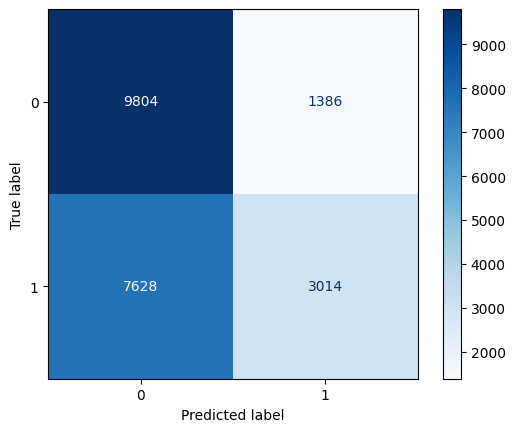

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, predictions_SVC))
disp_SVC=ConfusionMatrixDisplay.from_predictions(y_test, predictions_SVC, cmap=plt.cm.Blues)

We observe that the model classifies most of the generated texts correctly (9804 out of 11190). However, out of the total (10642) human texts, it only classifies correctly 3014. While the remaining 7628 human texts are classified as generated, meaning our model is not the best.

## Evaluation for each Domain in Test dataset

We will evaluate the performance of the SVM model for each of the domains *news* and *reviews*.


Classification Report for News:
              precision    recall  f1-score   support

   generated       0.52      0.85      0.64      5464
       human       0.58      0.21      0.31      5464

    accuracy                           0.53     10928
   macro avg       0.55      0.53      0.48     10928
weighted avg       0.55      0.53      0.48     10928

Classification Report for Reviews:
              precision    recall  f1-score   support

   generated       0.61      0.90      0.73      5726
       human       0.76      0.36      0.49      5178

    accuracy                           0.64     10904
   macro avg       0.69      0.63      0.61     10904
weighted avg       0.68      0.64      0.62     10904



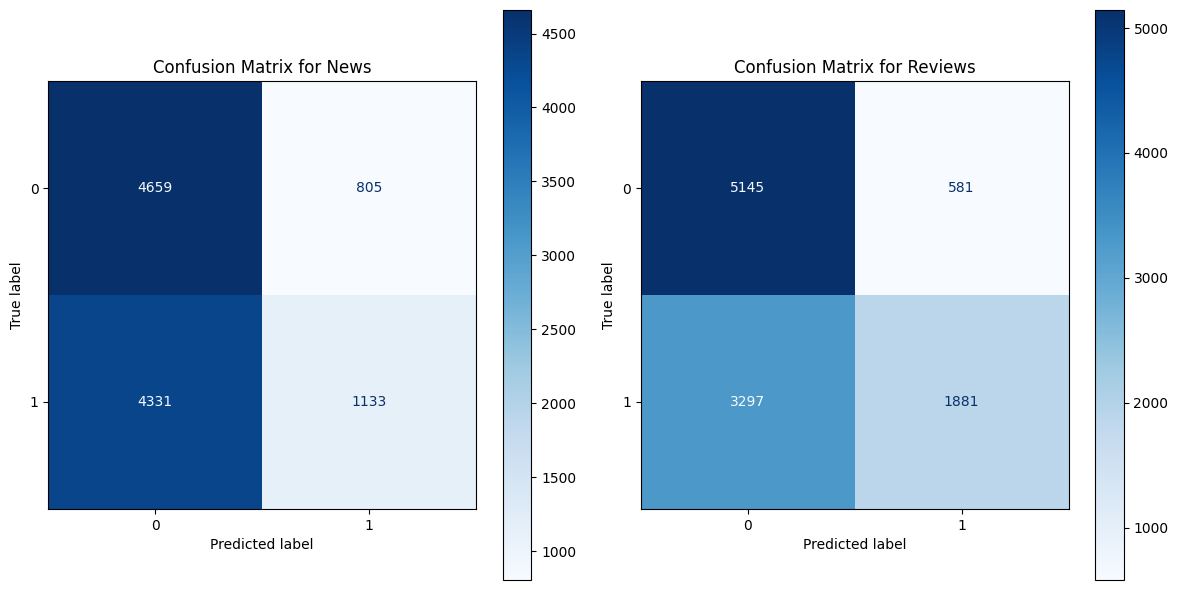

In [ ]:
# Calculate predictions and metrics for news domain
X_test_news = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'news']
y_test_news = y_test[domains_test=='news']
predictions_SVC_news = SVM_model.predict(X_test_news)
print("Classification Report for News:")
print(classification_report(y_test_news, predictions_SVC_news, target_names=labels))

# Calculate predictions and metrics for reviews domain
X_test_reviews = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'reviews']
y_test_reviews = y_test[domains_test=='reviews']
predictions_SVC_reviews = SVM_model.predict(X_test_reviews)
print("Classification Report for Reviews:")
print(classification_report(y_test_reviews, predictions_SVC_reviews, target_names=labels))

# Combine the confusion matrices plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp_SVC_news = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_news, predictions_SVC_news))
disp_SVC_news.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix for News')

disp_SVC_reviews = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_reviews, predictions_SVC_reviews))
disp_SVC_reviews.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('Confusion Matrix for Reviews')

plt.tight_layout()
plt.show()

We observe that the model does not categorize well the human written texts in the *news* domain (f1=0.31), and returns an overall macro F1s-score of 0.48.

For the *reviews* domain, we see that the score for human written texts it does better (f1=0.49) but still gives more than half of them are classified as false negatives. The  overall macro F1s-score is 0.61.